In [ ]:
#!pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user tensorflow-macos

In [ ]:
#!python --version

In [1]:
import os
import sys
import random

#TODO Make universal imports for all py files?

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#sys.modules['keras'] = keras

import numpy as np

from dice import dice_coef, dice_loss
from generator import DataGen
from visualize import display_slice_from_batch

seed = 2019
random.seed = seed
#TODO make config[seed] and fix below
#np.random.seed = seed
tf.seed = seed

In [2]:
#tf.debugging.set_log_device_placement(True)


In [3]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [4]:
patch_size = 32 # The size of the cube volumes in quickstart-gendata. You specified this in the previous notebook.
percent_covered = 1e-10
train_path = "quickstart-gendata/train"
model_path = "jan30_largeframe_32_nonzero_standardized_local.keras" # Name your model
epochs = 70
patience = 4
batch_size = 32

train_ids = next(os.walk(train_path))[1] # Returns all directories under train_path

val_data_size = 2 # Needs to be greater than batch_size

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=patch_size, patch_size=patch_size,
              percent_covered = percent_covered)
x, y = gen.__getitem__(0)
#0 - 37
print(x.shape, y.shape)

(32, 32, 32, 32, 1) (32, 32, 32, 32, 1)


(32, 32, 1)
4.46142179847967
1.0


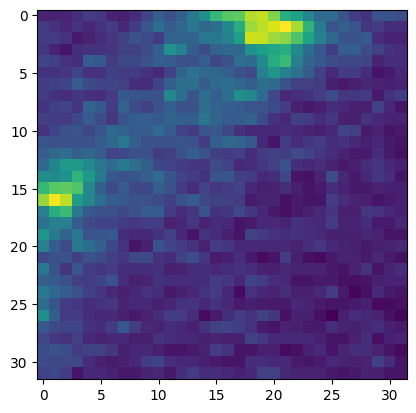

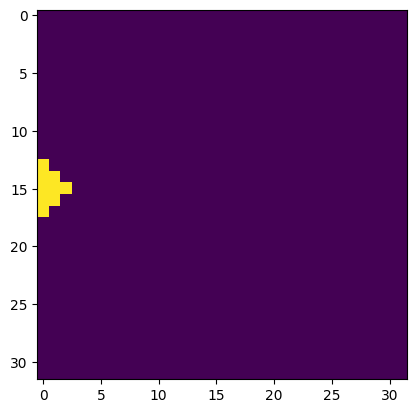

In [6]:
# View patches from the batch generated above.
# Change z to look at different slices.

n=0
z=30

display_slice_from_batch(x, n, z)
print(x[n, :, :, z].shape)
print(np.amax(x[n, :, :, z]))


display_slice_from_batch(y, n, z)
print(np.amax(y[n, :, :, :]))


In [7]:
# Neural network blocks
def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool3D((2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    us = keras.layers.Conv3DTranspose(filters*4, (2, 2, 2), (2, 2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
# Model Architecture
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [32, 64, 128, 256]
    inputs = keras.layers.Input((patch_size, patch_size, patch_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #32 -> 16
    c2, p2 = down_block(p1, f[1]) #16 -> 8
    c3, p3 = down_block(p2, f[2]) #8 -> 4
    #c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p3, f[3])
    
    u1 = up_block(bn, c3, f[2]) #4 -> 8
    u2 = up_block(u1, c2, f[1]) #8 -> 16
    u3 = up_block(u2, c1, f[0]) #16 -> 32
    #u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(u3)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
# Create model
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss(smooth=1.), metrics=[dice_coef, 'accuracy'])#, sample_weight_mode="temporal")
model.summary()

#TODO Does valid_gen use percent_covered = 0 or nonzero?
train_gen = DataGen(train_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)
valid_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)

2024-06-09 16:18:14.011172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-09 16:18:14.011231: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-09 16:18:14.011243: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-09 16:18:14.011289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-09 16:18:14.011313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32,    │     55,360 │ conv3d[0][0]      │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 16, 16,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16,    │    110,656 │ max_pooling3d[0]… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 16, 16,    │    221,312 │ conv3d_2[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 8, 8, 8,   │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 8, 8, 8,   │    442,496 │ max_pooling3d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 8, 8, 8,   │    884,992 │ conv3d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 4, 4, 4,   │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 4, 4, 4,   │  1,769,728 │ max_pooling3d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 4, 4, 4,   │  3,539,456 │ conv3d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 8, 8, 8,   │  2,097,664 │ conv3d_7[0][0]    │
│ (Conv3DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 8,   │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 768)              │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 8, 8, 8,   │  5,308,672 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 8, 8, 8,   │  1,769,728 │ conv3d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 16, 16,    │    524,544 │ conv3d_9[0][0]  

 Total params: 19,068,993 (72.74 MB)

 Trainable params: 19,068,993 (72.74 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)]

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=callbacks)

Epoch 1/70


2024-06-09 16:18:36.793429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/dnadeem/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8737 - dice_coef: 0.0160 - loss: -0.0164 
Epoch 1: val_loss improved from inf to -0.03498, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 115s 20s/step - accuracy: 0.8703 - dice_coef: 0.0160 - loss: -0.0166 - val_accuracy: 0.7248 - val_dice_coef: 0.0350 - val_loss: -0.0350 - learning_rate: 1.0000e-05
Epoch 2/70
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:07 32s/step - accuracy: 0.7786 - dice_coef: 0.0234 - loss: -0.0234

2024-06-09 16:21:02.602170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 16:21:02.602189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6888791784297816222
2024-06-09 16:21:02.602193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10426642736292053400
2024-06-09 16:21:02.602262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14577930950276022936
2024-06-09 16:21:02.602269: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2539010857647878188
2024-06-09 16:21:02.602273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1791479564991833146
2024-06-09 16:21:02.602276: I tensorflow/core/framework/local_rendezv


Epoch 2: val_loss improved from -0.03498 to -0.03562, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.7786 - dice_coef: 0.0140 - loss: -0.0234 - val_accuracy: 0.6972 - val_dice_coef: 0.0356 - val_loss: -0.0356 - learning_rate: 1.0000e-05
Epoch 3/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7456 - dice_coef: 0.0188 - loss: -0.0188
Epoch 3: val_loss improved from -0.03562 to -0.03910, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.7446 - dice_coef: 0.0189 - loss: -0.0189 - val_accuracy: 0.6251 - val_dice_coef: 0.0391 - val_loss: -0.0391 - learning_rate: 1.0000e-05
Epoch 4/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6671 - dice_coef: 0.0156 - loss: -0.0156
Epoch 4: val_loss improved from -0.03910 to -0.04265, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 

2024-06-09 16:23:30.499219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 16:23:30.499235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6888791784297816222
2024-06-09 16:23:30.499239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10426642736292053400
2024-06-09 16:23:30.499242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14577930950276022936
2024-06-09 16:23:30.499245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1791479564991833146
2024-06-09 16:23:30.499248: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8386691373907707520
2024-06-09 16:23:30.499250: I tensorflow/core/framework/local_rendezv


Epoch 8: val_loss improved from -0.06055 to -0.06643, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8700 - dice_coef: 0.0322 - loss: -0.0359 - val_accuracy: 0.8839 - val_dice_coef: 0.0664 - val_loss: -0.0664 - learning_rate: 1.0000e-05
Epoch 9/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8749 - dice_coef: 0.0344 - loss: -0.0344
Epoch 9: val_loss improved from -0.06643 to -0.07851, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8769 - dice_coef: 0.0348 - loss: -0.0348 - val_accuracy: 0.9217 - val_dice_coef: 0.0785 - val_loss: -0.0785 - learning_rate: 1.0000e-05
Epoch 10/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9076 - dice_coef: 0.0594 - loss: -0.0594
Epoch 10: val_loss improved from -0.07851 to -0.08549, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0

2024-06-09 16:25:44.008735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 16:25:44.008753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8089216111658594324
2024-06-09 16:25:44.008757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10426642736292053400
2024-06-09 16:25:44.008761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6888791784297816222
2024-06-09 16:25:44.008765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1791479564991833146
2024-06-09 16:25:44.008768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2539010857647878188
2024-06-09 16:25:44.008771: I tensorflow/core/framework/local_rendezvo


Epoch 17: val_loss improved from -0.16750 to -0.17601, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 692ms/step - accuracy: 0.9579 - dice_coef: 0.1218 - loss: -0.1486 - val_accuracy: 0.9723 - val_dice_coef: 0.1760 - val_loss: -0.1760 - learning_rate: 1.0000e-05
Epoch 18/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - dice_coef: 0.1318 - loss: -0.1318
Epoch 18: val_loss improved from -0.17601 to -0.18520, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9646 - dice_coef: 0.1281 - loss: -0.1281 - val_accuracy: 0.9819 - val_dice_coef: 0.1852 - val_loss: -0.1852 - learning_rate: 1.0000e-05
Epoch 19/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9737 - dice_coef: 0.1333 - loss: -0.1333
Epoch 19: val_loss did not improve from -0.18520
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9709 - dice_coef: 0.1319 - loss: -0.1319 - val_accuracy: 0.9651 - val

2024-06-09 16:28:54.892274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 16:28:54.892289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6888791784297816222
2024-06-09 16:28:54.892292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10426642736292053400
2024-06-09 16:28:54.892295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14577930950276022936
2024-06-09 16:28:54.892297: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10903308087991460492
2024-06-09 16:28:54.892300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1791479564991833146
2024-06-09 16:28:54.892302: I tensorflow/core/framework/local_rendez


Epoch 34: val_loss did not improve from -0.25406
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9760 - dice_coef: 0.1776 - loss: -0.1989 - val_accuracy: 0.9814 - val_dice_coef: 0.2540 - val_loss: -0.2540 - learning_rate: 5.0000e-06
Epoch 35/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9812 - dice_coef: 0.0872 - loss: -0.0872
Epoch 35: val_loss improved from -0.25406 to -0.25539, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9807 - dice_coef: 0.0846 - loss: -0.0846 - val_accuracy: 0.9816 - val_dice_coef: 0.2554 - val_loss: -0.2554 - learning_rate: 5.0000e-06
Epoch 36/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9681 - dice_coef: 0.1307 - loss: -0.1307
Epoch 36: val_loss improved from -0.25539 to -0.25887, saving model to jan30_largeframe_32_nonzero_standardized_local.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.9679 - dice_coef: 0.1329 - loss: -0.1329 - val_accuracy: 0.9812 - val_di

2024-06-09 16:32:19.593473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 16:32:19.593539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6888791784297816222
2024-06-09 16:32:19.593544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10426642736292053400
2024-06-09 16:32:19.593547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14577930950276022936
2024-06-09 16:32:19.593560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10903308087991460492
2024-06-09 16:32:19.593569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/


Epoch 51: val_loss did not improve from -0.30011
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9702 - dice_coef: 0.0723 - loss: -0.0828 - val_accuracy: 0.9819 - val_dice_coef: 0.2988 - val_loss: -0.2988 - learning_rate: 1.2500e-06
Epoch 52/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9781 - dice_coef: 0.1107 - loss: -0.1107
Epoch 52: val_loss did not improve from -0.30011

Epoch 52: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9774 - dice_coef: 0.1158 - loss: -0.1158 - val_accuracy: 0.9823 - val_dice_coef: 0.2957 - val_loss: -0.2957 - learning_rate: 1.2500e-06
Epoch 53/70
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - dice_coef: 0.1078 - loss: -0.1078
Epoch 53: val_loss did not improve from -0.30011
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9675 - dice_coef: 0.1160 - loss: -0.1160 - val_accuracy: 0.9824 - val_dice_coef: 0.2954 - val_loss: -0.2954 - learning_rate: 6.2500e-07
Epoch 54/

dict_keys(['accuracy', 'dice_coef', 'loss', 'val_accuracy', 'val_dice_coef', 'val_loss', 'learning_rate'])


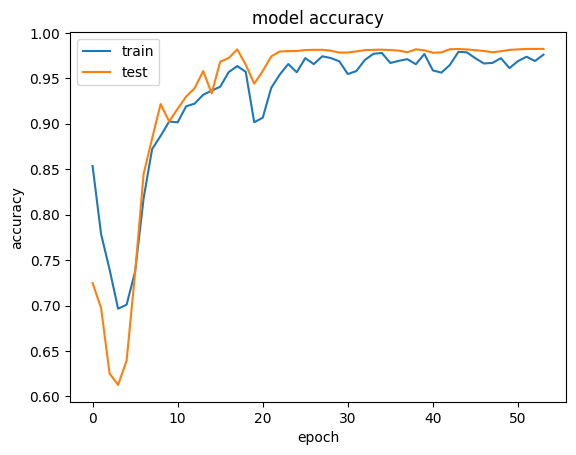

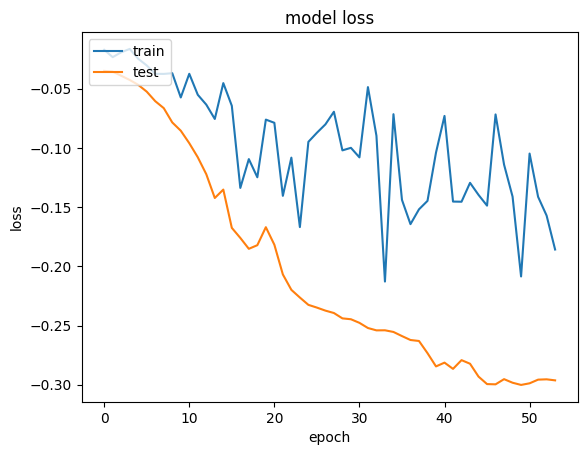

In [11]:
# View training statistics
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
(2, 32, 32, 32, 1)


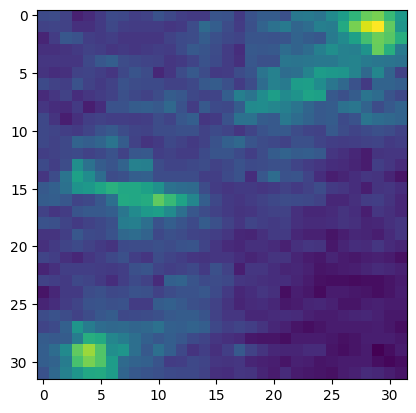

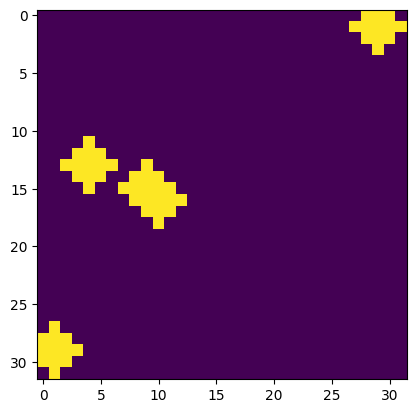

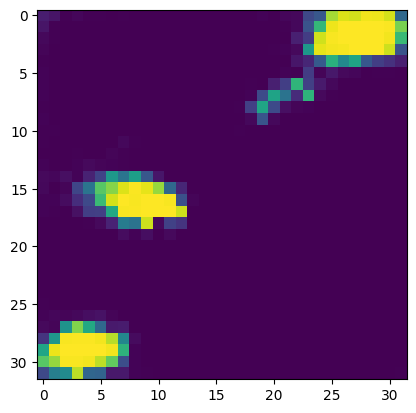

In [12]:
# Quickly view predictions on patches with the trained model.
# Predictions for larger data will need to be done in the next notebook.

test_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=0)
x, y = test_gen.__getitem__(0)
result = model.predict(x)

n=1
z=2

print(x.shape)
display_slice_from_batch(x,n,z)
display_slice_from_batch(y,n,z)
display_slice_from_batch(result,n,z)

In [13]:
# Run this if you want to save the training history
import pickle
with open('trainHistoryDict_overnight', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)